<a href="https://colab.research.google.com/github/gitGoogleConnect808/nlp-fake-news/blob/main/method-cnn/cnn-bagOfWords-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Colab Public Link: [Google Colab](https://colab.research.google.com/drive/1lX1W0rWz4DiPs5tpdRtW4ncj69d0zPyh?usp=drive_link)

## Section 1: create true and false df's
- paying attention only to certain true and false labels

In [ ]:
# For Colab only: Download data from public rep
! git clone https://github.com/gitGoogleConnect808/nlp-fake-news-data.git

Cloning into 'nlp-fake-news-data'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), 890.74 KiB | 2.24 MiB/s, done.


In [ ]:
import nltk
nltk.download('stopwords')
from nltk import FreqDist
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import csv
from sklearn import metrics

stops = stopwords.words('english')
stops.extend([",", ".", "!", "?", "'", '"', "I", "i", "n't", "'ve", "'d", "'s"])

allwords = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#create label to classification relations

#true, mostly-true, half-true, barely-true, false, pants-fire
true_labels = ['true', 'mostly-true']
false_labels = ['false', 'pants-fire']

#create map for each label and it's class (0/1)
label_mapping = {label: 1 for label in true_labels}
label_mapping.update({label: 0 for label in false_labels})


# Read in the training dataset
#tsv structure: statement: with properties => label, claim, class

column_names = ["label", "claim"]
train_df = pd.read_csv("nlp-fake-news-data/train.tsv", sep="\t", header=None, names=column_names, usecols=[1,2], quoting=csv.QUOTE_NONE)

In [ ]:
# create new column with 'class' being either 0/1 based on the label
# we'll also drop any claim row that doesn't have one of the labels we're looking at
def fixDataFrame(df, label_mapping):
    df['class'] = df['label'].str.strip().str.lower().map(label_mapping)
    return df.dropna(subset=['class'])

train_df = fixDataFrame(train_df, label_mapping)

In [ ]:
def checkDF(df):
    print("Sample of data entries:")
    print(df.sample(5, random_state=0))
    print(f"Total Entries: {len(df)}")

    counts = df['class'].value_counts()
    print(f"Count of 0's: {counts.get(0, 0)}")
    print(f"Count of 1's: {counts.get(1, 0)}")

#deug: check to make sure data frame looks right
checkDF(train_df)

Sample of data entries:
             label                                              claim  class
5679   mostly-true  I delivered to you a budget that ... cuts taxe...    1.0
10083        false  Says Will Rasmussen supported a sales tax as r...    0.0
4235   mostly-true  South Carolina has the fastest-growing economy...    1.0
9207          true  Says Ohio has 77 job training programs spread ...    1.0
977     pants-fire  Maj. Nidal Hasan, the man accused of the Fort ...    0.0
Total Entries: 6489
Count of 0's: 2840
Count of 1's: 3649


## Section 2: Turn true and false df's into true and false token lists

In [ ]:
# Create True media claims Data Frame
true_df = train_df[train_df['label'].isin(true_labels)]
print(f"True Claims Being Used: {len(true_df)}")

# Create Fake media claims Data Frame
fake_df = train_df[train_df['label'].isin(false_labels)]
print(f"Fake Articles Being Used: {len(fake_df)}")

True Claims Being Used: 3649
Fake Articles Being Used: 2840


In [ ]:
# Use max number
maxClaims = min(len(fake_df), len(true_df))
print(maxClaims)

2840


In [ ]:
# create 2d true_claims list, each row here represents the tokens of a claim.
true_claims = []
for i, (idx, statement) in enumerate(true_df.iterrows()):
    if i == maxClaims:
        break
    full_text = statement['claim']
    full_text = re.sub(r'[^\w\s]', ' ', full_text)
    full_text = re.sub(r'\d+', ' ', full_text)

    #debug
    #print(f"{i} {idx} {full_text}")

    words = full_text.lower().split()
    filtered_words = list(set([w for w in words if w not in stops]))
    true_claims.append(filtered_words)
    allwords.extend(filtered_words)

print(f"Processed {len(true_claims)} true media claims")


Processed 2840 true media claims


In [ ]:
# create 2d fake_claims list, each row here represents the tokens of a claim.
fake_claims = []
for i, (idx, statement) in enumerate(fake_df.iterrows()):
    if i == maxClaims:
        break
    full_text = statement['claim']
    full_text = re.sub(r'[^\w\s]', ' ', full_text)
    full_text = re.sub(r'\d+', ' ', full_text)

    #debug
    #print(f"{i} {idx} {full_text}")

    words = full_text.lower().split()
    filtered_words = list(set([w for w in words if w not in stops]))
    fake_claims.append(filtered_words)
    allwords.extend(filtered_words)

print(f"Processed {len(fake_claims)} false media claims")


Processed 2840 false media claims


In [ ]:
# Get the 1000 most frequent words
wfreq = FreqDist(allwords)
top1000 = wfreq.most_common(1000)

# 2d array where each row represents a claim and it is a vector of 0/1's representing what features were present in the claim
training = []
# 1d array, each elm is 1/0 (true/false claim) associated with some statement feature vector in testing list
trainingLabel = []

# Process true claims for training
print()
print("Feature vector:")
for claimTokenList in true_claims:
    featuresVect = []
    for topWord, freq in top1000:
        if topWord in claimTokenList:
            featuresVect.append(1)
        else:
            featuresVect.append(0)
    training.append(featuresVect)
    trainingLabel.append(1)  # 1 for true news

# Process fake claims for training
for claimTokenList in fake_claims:
    featuresVect = []
    for (topWord, _) in top1000:
        if topWord in claimTokenList:
            featuresVect.append(1)
        else:
            featuresVect.append(0)
    training.append(featuresVect)
    trainingLabel.append(0)  # 0 for fake news

print(f"Total Claims being used for Training: {len(trainingLabel)}")
print(f"Length of a Feature Vector: {len(training[0])}")


Feature vector:
Total Claims being used for Training: 5680
Length of a Feature Vector: 1000


In [ ]:
# Read in test tsv file of claims to be used for testing, filter out one's that won't be used
column_names = ['label', 'claim']
test_df = pd.read_csv("nlp-fake-news-data/test.tsv", sep="\t", header=None, names=column_names, usecols=[1,2], quoting=csv.QUOTE_NONE)
test_df = fixDataFrame(test_df, label_mapping)

#debug: check sample of data frame
checkDF(test_df)

Sample of data entries:
          label                                              claim  class
13        false  Says 57 percent of federal spending goes to th...    0.0
397       false  Gov. McDonnells proposed budget is cutting pub...    0.0
140       false  Virginia has made no progress on jobs since Bo...    0.0
667       false  On whether hes had a relationship with Vladimi...    0.0
22   pants-fire  The number of illegal immigrants could be 3 mi...    0.0
Total Entries: 802
Count of 0's: 342
Count of 1's: 460


In [ ]:
# Print test set stats
test_true_count = len(test_df[test_df['label'].isin(true_labels)])
test_fake_count = len(test_df[test_df['label'].isin(false_labels)])
print(f"\nTest dataset: {test_true_count} true articles, {test_fake_count} fake articles")


Test dataset: 460 true articles, 342 fake articles


In [ ]:
print(top1000[0])

('says', 1265)


In [ ]:
# clean up, tokenize statements for each claim in the test data frame

# 2d array where each row represents a claim and it is a vector of 0/1's representing what features were present in the claim
testing = []
# 1d array, each elm is 1/0 (true/false claim) associated with some statement feature vector in testing list
testingLabel = []

for (_, statement) in test_df.iterrows():
    full_text = statement['claim']
    full_text = re.sub(r'[^\w\s]', ' ', full_text)
    full_text = re.sub(r'\d+', ' ', full_text)
    words = full_text.lower().split()
    currentClaimTokens = list(set([w for w in words if w not in stops]))

    featuresVect = []
    for (topWord, _) in top1000:
        if topWord in currentClaimTokens:
            featuresVect.append(1)
        else:
            featuresVect.append(0)
    testing.append(featuresVect)

    # list that gets binary representation of claim being true (1) or false (0)
    if statement['label'].lower() in true_labels:
        testingLabel.append(1)
    elif statement['label'].lower() in false_labels:
        testingLabel.append(0)

print(f"Total Claims being tested on: {len(testingLabel)}")
print(f"Length of a Feature Vector: {len(testing[0])}")

Total Claims being tested on: 802
Length of a Feature Vector: 1000


## Section 3: Formatting 2d feature matrix and 1d claim answer to CNN ready ojects

- explanation for reshaping:
    - 3 dimensional:
    - x: batch size:
      - number of samples in dataset (training or testing)
      - Use: 2000 for training (50/50 split), 802 for testing
    - y: sequence length:
      - number of features per sample
      - Use: 1000, since each claim has 1000 features from top words list
    - z: features:
      - represents values in a feature
      - Use: 1 b/c 1 feature is a single number

In [ ]:
#format data to be in a specific shape for CNN

# format into numpy matrices
X_train = np.array(training)
X_test = np.array(testing)
y_train = np.array(trainingLabel)
y_test = np.array(testingLabel)

# reshaping
X_train = X_train.reshape(-1, 1000, 1)
X_test = X_test.reshape(-1, 1000, 1)

print('Shape of training data:')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data:')
print(X_test.shape)
print(y_test.shape)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten


Shape of training data:
(5680, 1000, 1)
(5680,)
Shape of test data:
(802, 1000, 1)
(802,)


In [ ]:
# Initialize and Compile the Model

# Initialize the model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1000, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Binary classification (true/fake)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Print summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 998, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 497, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 15872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,015,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,273 (3.90 MB)

 Trainable params: 1,022,273 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

## Section 4: Training The model

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5156 - loss: 0.6901 - val_accuracy: 0.5935 - val_loss: 0.6750
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5942 - loss: 0.6630 - val_accuracy: 0.5948 - val_loss: 0.6658
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6360 - loss: 0.6421 - val_accuracy: 0.6022 - val_loss: 0.6579
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6577 - loss: 0.6198 - val_accuracy: 0.6010 - val_loss: 0.6632
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6654 - loss: 0.6002 - val_accuracy: 0.6060 - val_loss: 0.6673
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7027 - loss: 0.5800 - val_accuracy: 0.6135 - val_loss: 0.6691
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7272 - loss: 0.5390 - val_accuracy: 0.5935 - val_loss: 0.6848
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7505 - loss: 0.5109 - val_accuracy: 0.5910 - v

## Section 5: Evaluation of The Model

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6038 - loss: 0.9905
Test accuracy: 0.6072


In [ ]:
# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



Test Results:
Precision: 0.6682
Recall: 0.6261
F1 Score: 0.6465
Confusion Matrix:
[[199 143]
 [172 288]]



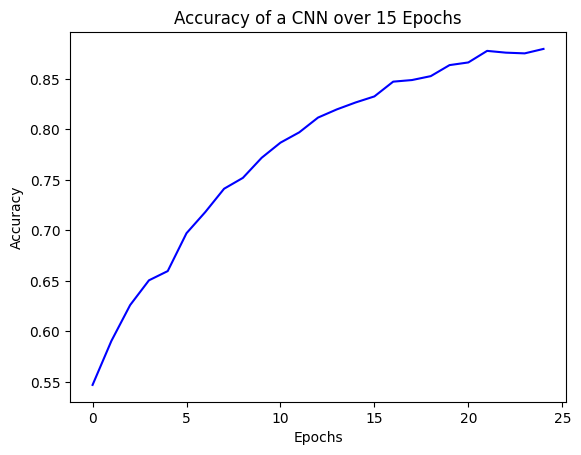

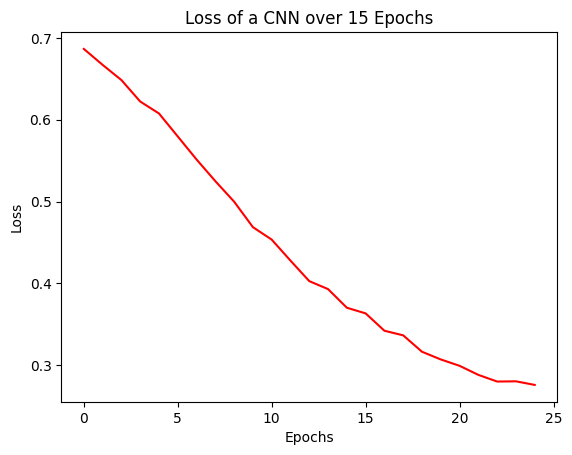

In [ ]:
print()
print("Test Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

print()
plt.plot(range(0,25), history.history['accuracy'], color = 'blue'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Accuracy of a CNN over 15 Epochs'); plt.show()
plt.plot(range(0,25), history.history['loss'], color = 'red'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Loss of a CNN over 15 Epochs'); plt.show()